In [ ]:
import sys
import torch

# Affiche quel Python votre notebook utilise
print(sys.executable) 

# Affiche la version de PyTorch qu'il a trouvée
print(torch.__version__) 

# Affiche où se trouve le fichier PyTorch
print(torch.__file__)

/Users/jordan/miniconda3/envs/general/bin/python
2.5.1
/Users/jordan/miniconda3/envs/general/lib/python3.11/site-packages/torch/__init__.py


In [ ]:
# --- 1. MISE EN PLACE ET IMPORTATIONS ---
# Importations standard de Pytorch et Torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os # Ajouté pour gérer les fichiers

print("Configuration initiale terminée.")

Configuration initiale terminée.


In [ ]:
# --- 2. PARAMÈTRES ET CHARGEMENT DES DONNÉES ---

# Paramètres de l'attaque PGD que nous allons utiliser
# Ce sont les "hyperparamètres" de notre génération de dataset
epsilon = 0.3    # Force maximale de l'attaque
alpha = 0.01     # Taille du pas à chaque itération
iters = 40       # Nombre d'itérations PGD (plus c'est élevé, meilleure est l'attaque)

# Définir le device (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

# Transformations pour MNIST
transform=transforms.Compose([
    transforms.ToTensor(),
    ])

# Charger le jeu de données MNIST
# Nous allons générer des attaques sur l'ensemble de test
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Données MNIST chargées.")

Utilisation du device : cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Données MNIST chargées.


In [ ]:
# --- 3. CHARGER LE MODÈLE "VICTIME" ---
# C'est le modèle que nous allons attaquer pour créer notre dataset.
# Nous réutilisons le modèle simple du tutoriel PyTorch.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Initialiser le modèle victime et le déplacer vers le device
victim_model = Net().to(device)

# Charger les poids pré-entraînés (fournis par le tutoriel)
# Assurez-vous d'avoir le fichier "mnist_cnn.pt" dans le même dossier
# ou de décommenter la ligne de téléchargement si vous ne l'avez pas.
model_path = "mnist_cnn.pt"

if not os.path.exists(model_path):
    print("Modèle pré-entraîné non trouvé. Téléchargement...")
    # Télécharger le modèle si vous ne l'avez pas
    !wget -q https://pytorch-tutorial-assets.s3.amazonaws.com/mnist_cnn.pt

victim_model.load_state_dict(torch.load(model_path, map_location=device))
victim_model.eval() # Mettre le modèle en mode évaluation (très important !)

print(f"Modèle victime '{model_path}' chargé et mis en mode évaluation.")

Modèle victime 'mnist_cnn.pt' chargé et mis en mode évaluation.


/var/folders/sy/c1_rq0_x6dgdg_c_vymm1lnw0000gn/T/ipykernel_37919/4212760845.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  victim_model.load_state_dict(torch.load(mode

In [ ]:
# --- 4. DÉFINIR LA FONCTION D'ATTAQUE PGD ---
# C'est la partie la plus importante.
# Nous créons une attaque PGD basée sur la logique de vos documents.
# La fonction retournera le BRUIT (delta), pas l'image attaquée.

def pgd_attack(model, images, labels, eps=0.3, alpha=0.01, iters=40):
    
    # Cloner les images pour ne pas modifier les originales
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    
    # Créer le tenseur de bruit (delta)
    # Il commence à zéro et c'est lui qu'on va optimiser
    delta = torch.zeros_like(images, requires_grad=True).to(device)
    
    for i in range(iters):
        # Image perturbée
        perturbed_image = images + delta
        
        # S'assurer que l'image reste dans les bornes [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        # Passer l'image dans le modèle
        output = model(perturbed_image)
        loss = F.nll_loss(output, labels)
        
        # Calculer le gradient de la perte par rapport au bruit (delta)
        model.zero_grad()
        loss.backward()
        
        # Mettre à jour le bruit (delta) en montant le gradient
        # C'est l'étape de maximisation de la perte [cite: 474]
        delta_update = alpha * delta.grad.detach().sign()
        delta.data = delta.data + delta_update
        
        # Projeter delta pour qu'il reste dans la boule L-infini (epsilon)
        delta.data = torch.clamp(delta.data, -eps, eps)
        
        # On s'assure aussi que l'image finale reste valide
        # C'est une projection L-infini ET une projection sur [0, 1]
        delta.data = torch.clamp(images + delta.data, 0, 1) - images

    # Renvoyer uniquement le bruit
    return delta.detach()


print("Fonction d'attaque PGD définie.")

Fonction d'attaque PGD définie.


In [ ]:
# --- 5. GÉNÉRER ET SAUVEGARDER LE DATASET ---
# Nous allons maintenant boucler sur tout le test_loader
# pour créer nos paires (image, bruit)

print("Début de la génération du dataset. Cela peut prendre quelques minutes...")

# Listes pour stocker les tenseurs
all_clean_images = []
all_adversarial_noise = []
all_labels = []

# Boucle principale
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    # Générer le bruit pour ce batch
    noise = pgd_attack(victim_model, images, labels, eps=epsilon, alpha=alpha, iters=iters)
    
    # Ajouter les résultats aux listes
    # On les déplace sur CPU pour libérer la mémoire GPU
    all_clean_images.append(images.cpu())
    all_adversarial_noise.append(noise.cpu())
    all_labels.append(labels.cpu())

# Concaténer tous les batches en deux grands tenseurs
clean_images_tensor = torch.cat(all_clean_images, dim=0)
noise_tensor = torch.cat(all_adversarial_noise, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

print(f"Génération terminée. Tenseurs créés :")
print(f"Images (X): {clean_images_tensor.shape}")
print(f"Bruit (Y):  {noise_tensor.shape}")
print(f"Labels:     {labels_tensor.shape}")


# Sauvegarder les tenseurs sur le disque
torch.save(clean_images_tensor, 'dataset_clean_images.pt')
torch.save(noise_tensor, 'dataset_adv_noise.pt')
torch.save(labels_tensor, 'dataset_labels.pt')

print("Dataset sauvegardé ! Fichiers créés :")
print("- dataset_clean_images.pt (Les X de votre générateur)")
print("- dataset_adv_noise.pt (Les Y, 'ground truth', de votre générateur)")
print("- dataset_labels.pt (Utile pour vérifier les attaques)")


Début de la génération du dataset. Cela peut prendre quelques minutes...
Génération terminée. Tenseurs créés :
Images (X): torch.Size([10000, 1, 28, 28])
Bruit (Y):  torch.Size([10000, 1, 28, 28])
Labels:     torch.Size([10000])
Dataset sauvegardé ! Fichiers créés :
- dataset_clean_images.pt (Les X de votre générateur)
- dataset_adv_noise.pt (Les Y, 'ground truth', de votre générateur)
- dataset_labels.pt (Utile pour vérifier les attaques)



Vérification d'un échantillon...


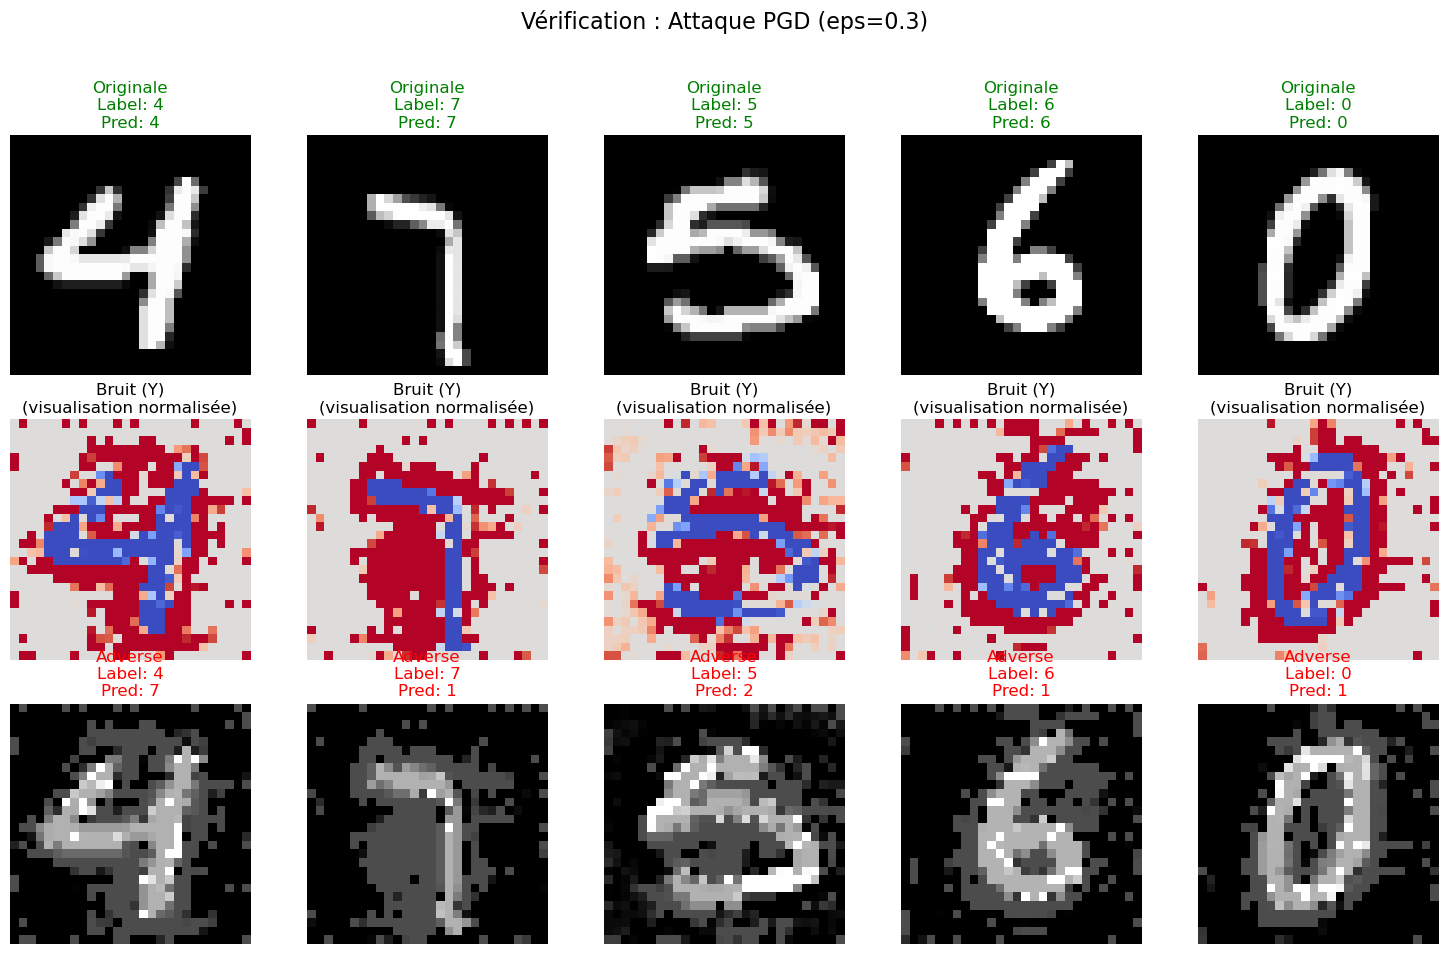


--- FIN DU NOTEBOOK ---
Vous avez maintenant les fichiers pour entraîner votre générateur d'attaques.


In [ ]:
# --- 6. VÉRIFICATION (Optionnel mais recommandé) ---

print("\nVérification d'un échantillon...")

# Prendre 5 images au hasard
indices = np.random.choice(len(clean_images_tensor), 5, replace=False)
sample_images = clean_images_tensor[indices].to(device)
sample_noise = noise_tensor[indices].to(device)
sample_labels = labels_tensor[indices].to(device)

# Créer les images adverses en ajoutant le bruit
adv_images = torch.clamp(sample_images + sample_noise, 0, 1)

# Obtenir les prédictions
with torch.no_grad():
    pred_clean = victim_model(sample_images).argmax(dim=1)
    pred_adv = victim_model(adv_images).argmax(dim=1)

# Afficher les résultats
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle(f"Vérification : Attaque PGD (eps={epsilon})", fontsize=16)

for i in range(5):
    # Image originale
    axes[0, i].imshow(sample_images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].set_title(f"Originale\nLabel: {sample_labels[i].item()}\nPred: {pred_clean[i].item()}",
                         color=("green" if pred_clean[i] == sample_labels[i] else "red"))
    axes[0, i].axis('off')
    
    # Bruit (le "Y" de votre futur modèle)
    # On normalise le bruit pour l'afficher, sinon il est quasi invisible
    noise_viz = (sample_noise[i].cpu().squeeze() - sample_noise[i].min()) / (sample_noise[i].max() - sample_noise[i].min())
    axes[1, i].imshow(noise_viz, cmap="coolwarm")
    axes[1, i].set_title("Bruit (Y)\n(visualisation normalisée)")
    axes[1, i].axis('off')

    # Image adverse
    axes[2, i].imshow(adv_images[i].cpu().squeeze(), cmap="gray")
    axes[2, i].set_title(f"Adverse\nLabel: {sample_labels[i].item()}\nPred: {pred_adv[i].item()}",
                         color=("red" if pred_adv[i] != sample_labels[i] else "green"))
    axes[2, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- FIN DU NOTEBOOK ---")
print("Vous avez maintenant les fichiers pour entraîner votre générateur d'attaques.")

### Counting Parameters

In [ ]:
import torch
import torch.nn as nn
from diffusers import UNet2DModel, UNet2DConditionModel

def count_parameters(model):
    """
    Compte et affiche le nombre de paramètres entraînables d'un modèle.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Formate le nombre avec des séparateurs de milliers
    print(f"Modèle: {model.__class__.__name__}")
    print(f" -> Paramètres entraînables: {total_params:,}")
    return total_params

# --- 1. Comptage pour UNet2DModel (Non-conditionnel) ---

print("--- 1. Comptage pour UNet2DModel (Non-conditionnel) ---")

# Configuration exacte de notre Partie 1 (avec attention simple)
config_non_cond = {
    "sample_size": 28,         # MNIST est 28x28
    "in_channels": 1,          # 1 canal d'entrée
    "out_channels": 1,         # 1 canal de sortie (le bruit)
    "layers_per_block": 2,
    "block_out_channels": (32, 64, 128, 128), # Canaux à chaque étage
    "down_block_types": (      # Blocs pour la descente (Encodeur)
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D"   # Attention simple
    ),
    "up_block_types": (        # Blocs pour la remontée (Décodeur)
        "AttnUpBlock2D",    # Attention simple
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"
    ),
    "add_attention": True
}

# Instanciation du modèle
unet_non_cond = UNet2DModel(**config_non_cond)

# Comptage
params_non_cond = count_parameters(unet_non_cond)


# --- 2. Comptage pour UNet2DConditionModel (Conditionnel) ---

print("\n--- 2. Comptage pour UNet2DConditionModel (Conditionnel) ---")

# Notre modèle conditionnel est composé de DEUX parties :
# 1. Le module d'embedding pour epsilon
# 2. Le U-Net conditionnel lui-même

# 1. Module d'embedding (de notre Partie 3)
class EpsilonEmbedding(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
    def forward(self, epsilon_val):
        return self.net(epsilon_val)

cross_attention_dim = 128  # La dimension de notre condition

# Instanciation de l'embedder
epsilon_embedder = EpsilonEmbedding(output_dim=cross_attention_dim)
params_embedder = count_parameters(epsilon_embedder)


# --- 2. Comptage pour UNet2DConditionModel (Conditionnel) ---

print("\n--- 2. Comptage pour UNet2DConditionModel (Conditionnel) ---")

# (La classe EpsilonEmbedding reste la même)
class EpsilonEmbedding(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
    def forward(self, epsilon_val):
        return self.net(epsilon_val)

cross_attention_dim = 128
epsilon_embedder = EpsilonEmbedding(output_dim=cross_attention_dim)
params_embedder = count_parameters(epsilon_embedder)

# 2. Le U-Net Conditionnel (de notre Partie 3)
config_cond = {
    "sample_size": 28,
    "in_channels": 1,
    "out_channels": 1,
    "cross_attention_dim": cross_attention_dim, 
    "layers_per_block": 2,
    "block_out_channels": (32, 64, 128, 128),
    "down_block_types": (
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "CrossAttnDownBlock2D" 
    ),
    "up_block_types": (
        "CrossAttnUpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"
    ),
    # "add_attention": True  <-- LIGNE SUPPRIMÉE
}

# Instanciation du modèle (maintenant correcte)
unet_cond = UNet2DConditionModel(**config_cond)

# Comptage
params_unet_cond = count_parameters(unet_cond)


# --- 3. Total ---
print("\n-------------------------------------------")
print(f"TOTAL (Modèle Conditionnel + Embedder): {params_embedder + params_unet_cond:,}")


# --- 3. Total ---
print("\n-------------------------------------------")
print(f"TOTAL (Modèle Conditionnel + Embedder): {params_embedder + params_unet_cond:,}")


--- 1. Comptage pour UNet2DModel (Non-conditionnel) ---
Modèle: UNet2DModel
 -> Paramètres entraînables: 6,337,345

--- 2. Comptage pour UNet2DConditionModel (Conditionnel) ---
Modèle: EpsilonEmbedding
 -> Paramètres entraînables: 16,768

--- 2. Comptage pour UNet2DConditionModel (Conditionnel) ---
Modèle: EpsilonEmbedding
 -> Paramètres entraînables: 16,768
Modèle: UNet2DConditionModel
 -> Paramètres entraînables: 8,118,337

-------------------------------------------
TOTAL (Modèle Conditionnel + Embedder): 8,135,105

-------------------------------------------
TOTAL (Modèle Conditionnel + Embedder): 8,135,105
